In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, mask_name, image_type

In [6]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = train_augmentation, image_size = image_size)
# train_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
# test_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, mask_name, image_type = next(iter(test_dataloader))

In [7]:
image.shape

torch.Size([101, 1, 128, 128])

In [8]:
print(len(train_dataset), len(test_dataset))

169 112


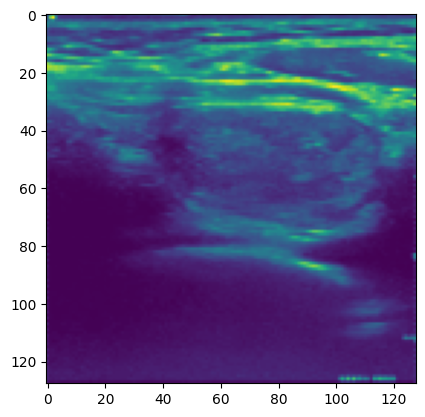

In [9]:
plt.imshow(image[18][0])

In [10]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [11]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [12]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [13]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [16]:

epochs = 500
lr = 0.005
loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [15]:

project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale(0.7)_Tversky_loss"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [17]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [18]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


train loss : 0.3928341865539551, train IOU : 0.4227225184440613, train DICE : 0.6071657836437225


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16190695762634277, val IOU : 0.7236670851707458, val DICE : 0.8380929827690125
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.33502116799354553, train IOU : 0.5169455707073212, train DICE : 0.6649788320064545


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15876919031143188, val IOU : 0.7381787896156311, val DICE : 0.8412308096885681
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.305316299200058, train IOU : 0.5464910864830017, train DICE : 0.694683700799942


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1797957420349121, val IOU : 0.699698269367218, val DICE : 0.8202043771743774
epoch : 3


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.30322930216789246, train IOU : 0.5088750720024109, train DICE : 0.6967706978321075


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15022695064544678, val IOU : 0.7323600053787231, val DICE : 0.8497730493545532
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2892429232597351, train IOU : 0.5217574834823608, train DICE : 0.7107571065425873


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15198159217834473, val IOU : 0.7271719574928284, val DICE : 0.8480184078216553
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.32661953568458557, train IOU : 0.49025723338127136, train DICE : 0.6733804941177368


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16936618089675903, val IOU : 0.7022867202758789, val DICE : 0.8306337594985962
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2576793134212494, train IOU : 0.5327217876911163, train DICE : 0.7423207461833954


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.2079681158065796, val IOU : 0.6636123061180115, val DICE : 0.79203200340271
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.27285656332969666, train IOU : 0.5618195235729218, train DICE : 0.7271434366703033


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.21301567554473877, val IOU : 0.6770616173744202, val DICE : 0.7869843244552612
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.25509244203567505, train IOU : 0.5641064643859863, train DICE : 0.7449075877666473


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.16309505701065063, val IOU : 0.738227903842926, val DICE : 0.8369049429893494
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.23720845580101013, train IOU : 0.5890314280986786, train DICE : 0.7627915441989899


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.17074698209762573, val IOU : 0.7225861549377441, val DICE : 0.829253077507019
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2596462368965149, train IOU : 0.5937182009220123, train DICE : 0.7403537034988403


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16599595546722412, val IOU : 0.7306501269340515, val DICE : 0.8340040445327759
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2901628613471985, train IOU : 0.5563540458679199, train DICE : 0.7098371684551239


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16967624425888062, val IOU : 0.7351311445236206, val DICE : 0.8303236961364746
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.26591041684150696, train IOU : 0.5565731525421143, train DICE : 0.734089583158493


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1761857271194458, val IOU : 0.72824627161026, val DICE : 0.8238141536712646
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.25247132778167725, train IOU : 0.5709593892097473, train DICE : 0.7475286722183228


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16269207000732422, val IOU : 0.7379555106163025, val DICE : 0.8373080492019653
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.24103179574012756, train IOU : 0.5554772615432739, train DICE : 0.7589681446552277


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15946358442306519, val IOU : 0.7375770211219788, val DICE : 0.8405364155769348
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2506164610385895, train IOU : 0.5840453803539276, train DICE : 0.7493835687637329


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.162583589553833, val IOU : 0.7343047261238098, val DICE : 0.837416410446167
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.273894339799881, train IOU : 0.5571700036525726, train DICE : 0.7261056303977966


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.17095619440078735, val IOU : 0.725675642490387, val DICE : 0.8290438055992126
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.23769450187683105, train IOU : 0.5731470584869385, train DICE : 0.7623055577278137


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.18205136060714722, val IOU : 0.7183640003204346, val DICE : 0.8179486393928528
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2590138018131256, train IOU : 0.5831222236156464, train DICE : 0.7409861981868744


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.18692243099212646, val IOU : 0.7180527448654175, val DICE : 0.8130775690078735
epoch : 19


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.26016324758529663, train IOU : 0.5883374512195587, train DICE : 0.7398367822170258


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17467617988586426, val IOU : 0.7252909541130066, val DICE : 0.8253238201141357
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.21370872855186462, train IOU : 0.6287125647068024, train DICE : 0.7862912714481354


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16649800539016724, val IOU : 0.7301706671714783, val DICE : 0.8335019946098328
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22673389315605164, train IOU : 0.6083588898181915, train DICE : 0.7732661068439484


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1620616912841797, val IOU : 0.7372854948043823, val DICE : 0.8379383683204651
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.20367038249969482, train IOU : 0.6387057602405548, train DICE : 0.7963296175003052


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.16697806119918823, val IOU : 0.7335233092308044, val DICE : 0.8330219388008118
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.20519089698791504, train IOU : 0.6290597319602966, train DICE : 0.7948090136051178


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16536086797714233, val IOU : 0.7379614114761353, val DICE : 0.8346391320228577
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2649950683116913, train IOU : 0.6030967831611633, train DICE : 0.7350049316883087


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1867508888244629, val IOU : 0.7091345191001892, val DICE : 0.8132491111755371
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.2120133638381958, train IOU : 0.6165089905261993, train DICE : 0.7879865765571594


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.22161680459976196, val IOU : 0.6587730050086975, val DICE : 0.778383195400238
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2065635621547699, train IOU : 0.620408684015274, train DICE : 0.7934364676475525


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.2006930112838745, val IOU : 0.6902240514755249, val DICE : 0.7993070483207703
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2069518268108368, train IOU : 0.6421008706092834, train DICE : 0.7930482029914856


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16693037748336792, val IOU : 0.7324404716491699, val DICE : 0.8330696225166321
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22169584035873413, train IOU : 0.6293580532073975, train DICE : 0.7783041894435883


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1574869155883789, val IOU : 0.7400055527687073, val DICE : 0.8425130844116211
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1986846625804901, train IOU : 0.6271277070045471, train DICE : 0.8013153374195099


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.1561039686203003, val IOU : 0.741471529006958, val DICE : 0.8438959717750549
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.23547601699829102, train IOU : 0.5986064970493317, train DICE : 0.764523983001709


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15567636489868164, val IOU : 0.7451407313346863, val DICE : 0.8443236351013184
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.18702977895736694, train IOU : 0.6488035321235657, train DICE : 0.8129703104496002


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.15726977586746216, val IOU : 0.7464848756790161, val DICE : 0.8427302241325378
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.20185047388076782, train IOU : 0.6320270001888275, train DICE : 0.7981495261192322


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16839206218719482, val IOU : 0.728571355342865, val DICE : 0.83160799741745
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.20018425583839417, train IOU : 0.635728269815445, train DICE : 0.7998157441616058


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.19427484273910522, val IOU : 0.6890782713890076, val DICE : 0.8057251572608948
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19039791822433472, train IOU : 0.6541948020458221, train DICE : 0.8096020817756653


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17666935920715332, val IOU : 0.7169107794761658, val DICE : 0.8233307003974915
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21686282753944397, train IOU : 0.6174340844154358, train DICE : 0.783137172460556


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.16475141048431396, val IOU : 0.7355288863182068, val DICE : 0.835248589515686
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.20054495334625244, train IOU : 0.6198815107345581, train DICE : 0.7994550466537476


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16535067558288574, val IOU : 0.7298804521560669, val DICE : 0.834649384021759
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.20215550065040588, train IOU : 0.6401922106742859, train DICE : 0.7978444993495941


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15283316373825073, val IOU : 0.7445944547653198, val DICE : 0.847166895866394
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19682738184928894, train IOU : 0.644111841917038, train DICE : 0.8031726181507111


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15347105264663696, val IOU : 0.7471392154693604, val DICE : 0.8465290665626526
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.17435115575790405, train IOU : 0.6520919501781464, train DICE : 0.8256489038467407


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16471338272094727, val IOU : 0.7365716695785522, val DICE : 0.8352866768836975
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18340829014778137, train IOU : 0.6696158051490784, train DICE : 0.8165916502475739


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.186876118183136, val IOU : 0.7051487565040588, val DICE : 0.813123881816864
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.18585854768753052, train IOU : 0.6628977954387665, train DICE : 0.8141414821147919


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.21509826183319092, val IOU : 0.66729736328125, val DICE : 0.7849017381668091
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.20048397779464722, train IOU : 0.6418598592281342, train DICE : 0.7995160222053528


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.20657163858413696, val IOU : 0.6817113161087036, val DICE : 0.793428361415863
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17561593651771545, train IOU : 0.6639707684516907, train DICE : 0.8243840038776398


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16242927312850952, val IOU : 0.7400851249694824, val DICE : 0.8375706672668457
epoch : 44


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21338462829589844, train IOU : 0.6188840568065643, train DICE : 0.7866153717041016


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15331166982650757, val IOU : 0.7463067770004272, val DICE : 0.8466882705688477
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.2082924246788025, train IOU : 0.6027058660984039, train DICE : 0.7917075753211975


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.15336871147155762, val IOU : 0.7437430024147034, val DICE : 0.8466312289237976
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17530301213264465, train IOU : 0.6683390438556671, train DICE : 0.8246970176696777


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16021615266799927, val IOU : 0.7377104759216309, val DICE : 0.8397839665412903
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1850496530532837, train IOU : 0.6507970690727234, train DICE : 0.8149503469467163


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.1654227375984192, val IOU : 0.7359317541122437, val DICE : 0.8345772624015808
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1618654429912567, train IOU : 0.7029117345809937, train DICE : 0.8381345570087433


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.16632354259490967, val IOU : 0.7368469834327698, val DICE : 0.8336764574050903
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.175956130027771, train IOU : 0.6832069754600525, train DICE : 0.824043869972229


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.18247288465499878, val IOU : 0.7158839106559753, val DICE : 0.8175271153450012
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.16157671809196472, train IOU : 0.6857796013355255, train DICE : 0.8384232521057129


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.18539196252822876, val IOU : 0.7122136950492859, val DICE : 0.814608097076416
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19989144802093506, train IOU : 0.6363001465797424, train DICE : 0.8001085519790649


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16725480556488037, val IOU : 0.7343041300773621, val DICE : 0.8327453136444092
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.16076454520225525, train IOU : 0.6880016028881073, train DICE : 0.8392354547977448


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15926527976989746, val IOU : 0.7431557178497314, val DICE : 0.8407347202301025
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19960039854049683, train IOU : 0.6658594906330109, train DICE : 0.8003996312618256


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15335839986801147, val IOU : 0.7496925592422485, val DICE : 0.846641480922699
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19556573033332825, train IOU : 0.6581379175186157, train DICE : 0.8044342696666718


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15800750255584717, val IOU : 0.743207573890686, val DICE : 0.8419923782348633
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18175008893013, train IOU : 0.671379804611206, train DICE : 0.81824991106987


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15772277116775513, val IOU : 0.7465717196464539, val DICE : 0.8422771692276001
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16675615310668945, train IOU : 0.676476240158081, train DICE : 0.8332438468933105


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.17007720470428467, val IOU : 0.7323251962661743, val DICE : 0.8299227952957153
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.16979393362998962, train IOU : 0.6770224869251251, train DICE : 0.8302060961723328


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.18190205097198486, val IOU : 0.7132343053817749, val DICE : 0.8180979490280151
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17626377940177917, train IOU : 0.679989367723465, train DICE : 0.8237362504005432


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.18006479740142822, val IOU : 0.7145645618438721, val DICE : 0.819935142993927
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.15668967366218567, train IOU : 0.6992306709289551, train DICE : 0.8433103561401367


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1730024814605713, val IOU : 0.7226560115814209, val DICE : 0.8269975185394287
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1722315549850464, train IOU : 0.6588591933250427, train DICE : 0.827768474817276


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15880054235458374, val IOU : 0.7444164156913757, val DICE : 0.8411994576454163
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1629062294960022, train IOU : 0.6916800737380981, train DICE : 0.837093710899353


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15516990423202515, val IOU : 0.7479701042175293, val DICE : 0.8448300957679749
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16168281435966492, train IOU : 0.677827000617981, train DICE : 0.8383172452449799


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15548723936080933, val IOU : 0.7479965686798096, val DICE : 0.8445127606391907
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.17031115293502808, train IOU : 0.6736923158168793, train DICE : 0.8296888470649719


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15865784883499146, val IOU : 0.7448912262916565, val DICE : 0.8413421511650085
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1549905240535736, train IOU : 0.6923182308673859, train DICE : 0.845009446144104


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15660887956619263, val IOU : 0.7469137907028198, val DICE : 0.8433910608291626
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17479097843170166, train IOU : 0.6683477163314819, train DICE : 0.8252090513706207


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15836042165756226, val IOU : 0.7452167868614197, val DICE : 0.8416395783424377
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16645383834838867, train IOU : 0.6616792976856232, train DICE : 0.8335461318492889


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16828513145446777, val IOU : 0.7325010299682617, val DICE : 0.8317148685455322
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18287765979766846, train IOU : 0.6648189127445221, train DICE : 0.8171223402023315


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1631290316581726, val IOU : 0.7406526803970337, val DICE : 0.8368709683418274
epoch : 68


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16320684552192688, train IOU : 0.6967422664165497, train DICE : 0.8367931544780731


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1570238471031189, val IOU : 0.7500054240226746, val DICE : 0.8429761528968811
epoch : 69


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.15900957584381104, train IOU : 0.7010289132595062, train DICE : 0.840990424156189


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15396851301193237, val IOU : 0.7531333565711975, val DICE : 0.8460314869880676
epoch : 70


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1553223729133606, train IOU : 0.7073118090629578, train DICE : 0.8446776568889618


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16323745250701904, val IOU : 0.7357288002967834, val DICE : 0.8367626070976257
epoch : 71


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1944901943206787, train IOU : 0.6509939134120941, train DICE : 0.8055097758769989


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.1525554060935974, val IOU : 0.7511079907417297, val DICE : 0.8474445939064026
epoch : 72


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1553368866443634, train IOU : 0.6989330351352692, train DICE : 0.8446632027626038


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15742629766464233, val IOU : 0.7429519295692444, val DICE : 0.8425737023353577
epoch : 73


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1701919436454773, train IOU : 0.6791464388370514, train DICE : 0.8298080563545227


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16022729873657227, val IOU : 0.7425727248191833, val DICE : 0.8397727012634277
epoch : 74


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.15275156497955322, train IOU : 0.7135024070739746, train DICE : 0.8472484350204468


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.16993200778961182, val IOU : 0.7307553887367249, val DICE : 0.8300679326057434
epoch : 75


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1756344437599182, train IOU : 0.6884109079837799, train DICE : 0.8243655264377594


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.15924900770187378, val IOU : 0.742077648639679, val DICE : 0.840751051902771
epoch : 76


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17762652039527893, train IOU : 0.6582613587379456, train DICE : 0.8223734796047211


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.15190404653549194, val IOU : 0.7523388266563416, val DICE : 0.8480959534645081
epoch : 77


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1649366021156311, train IOU : 0.6741064190864563, train DICE : 0.8350634872913361


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.1573960781097412, val IOU : 0.7482831478118896, val DICE : 0.8426039218902588
epoch : 78


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16603553295135498, train IOU : 0.6955617964267731, train DICE : 0.833964467048645


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15605515241622925, val IOU : 0.7507245540618896, val DICE : 0.8439448475837708
epoch : 79


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.15420037508010864, train IOU : 0.713860958814621, train DICE : 0.8457996249198914


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1639772653579712, val IOU : 0.7386955618858337, val DICE : 0.8360227346420288
epoch : 80


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.16776609420776367, train IOU : 0.6803571581840515, train DICE : 0.8322339057922363


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.17417705059051514, val IOU : 0.7237297892570496, val DICE : 0.8258230090141296
epoch : 81


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17829161882400513, train IOU : 0.6954046785831451, train DICE : 0.8217083811759949


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1608867049217224, val IOU : 0.7427040338516235, val DICE : 0.8391132950782776
epoch : 82


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.14677250385284424, train IOU : 0.6965824663639069, train DICE : 0.8532275259494781


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15536880493164062, val IOU : 0.748735785484314, val DICE : 0.8446313142776489
epoch : 83


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.16704416275024414, train IOU : 0.6991146504878998, train DICE : 0.8329558968544006


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1541835069656372, val IOU : 0.7470077276229858, val DICE : 0.8458163738250732
epoch : 84


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14659088850021362, train IOU : 0.7108579874038696, train DICE : 0.853409081697464


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15793496370315552, val IOU : 0.7422285676002502, val DICE : 0.8420650362968445
epoch : 85


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1441034972667694, train IOU : 0.7184132635593414, train DICE : 0.8558965027332306


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1657649278640747, val IOU : 0.7318456768989563, val DICE : 0.8342350125312805
epoch : 86


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17656570672988892, train IOU : 0.6760530471801758, train DICE : 0.8234342932701111


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15701597929000854, val IOU : 0.745516300201416, val DICE : 0.8429840803146362
epoch : 87


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.14975515007972717, train IOU : 0.7100581228733063, train DICE : 0.8502448499202728


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15442872047424316, val IOU : 0.750735342502594, val DICE : 0.8455712795257568
epoch : 88


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16397356986999512, train IOU : 0.7255330979824066, train DICE : 0.8360264599323273


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15951752662658691, val IOU : 0.7457903623580933, val DICE : 0.8404824733734131
epoch : 89


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1509387195110321, train IOU : 0.7031944394111633, train DICE : 0.8490613400936127


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1685858964920044, val IOU : 0.7348563075065613, val DICE : 0.8314141035079956
epoch : 90


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14408159255981445, train IOU : 0.7276886999607086, train DICE : 0.8559184074401855


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16764873266220093, val IOU : 0.7373830080032349, val DICE : 0.8323512673377991
epoch : 91


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16068121790885925, train IOU : 0.715142697095871, train DICE : 0.8393187820911407


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15903377532958984, val IOU : 0.7481580376625061, val DICE : 0.8409662246704102
epoch : 92


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14818844199180603, train IOU : 0.7162515819072723, train DICE : 0.851811558008194


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15870416164398193, val IOU : 0.7440915703773499, val DICE : 0.8412959575653076
epoch : 93


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.14504075050354004, train IOU : 0.7136368155479431, train DICE : 0.85495924949646


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15323472023010254, val IOU : 0.748796820640564, val DICE : 0.846765398979187
epoch : 94


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16408231854438782, train IOU : 0.6799523830413818, train DICE : 0.8359176814556122


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1477816104888916, val IOU : 0.7559823393821716, val DICE : 0.8522182703018188
epoch : 95


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14746493101119995, train IOU : 0.7015803158283234, train DICE : 0.8525350391864777


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14897489547729492, val IOU : 0.7528359889984131, val DICE : 0.8510251045227051
epoch : 96


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.13811373710632324, train IOU : 0.7507558465003967, train DICE : 0.8618862628936768


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15463203191757202, val IOU : 0.7465547323226929, val DICE : 0.8453678488731384
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15531888604164124, train IOU : 0.7193540632724762, train DICE : 0.8446811139583588


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15872317552566528, val IOU : 0.7436534762382507, val DICE : 0.8412767052650452
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1407945454120636, train IOU : 0.7216134071350098, train DICE : 0.859205424785614


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15666407346725464, val IOU : 0.7451986074447632, val DICE : 0.8433359265327454
epoch : 99


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1400417983531952, train IOU : 0.7396158576011658, train DICE : 0.8599582016468048


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15205949544906616, val IOU : 0.7519084215164185, val DICE : 0.8479405045509338
epoch : 100


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15700209140777588, train IOU : 0.6940396726131439, train DICE : 0.8429979085922241


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15101134777069092, val IOU : 0.7525522708892822, val DICE : 0.8489887118339539
epoch : 101


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.13783013820648193, train IOU : 0.7200401127338409, train DICE : 0.8621698915958405


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15001213550567627, val IOU : 0.7553200125694275, val DICE : 0.8499878644943237
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.13087114691734314, train IOU : 0.7412859201431274, train DICE : 0.8691288232803345


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14497250318527222, val IOU : 0.7622714042663574, val DICE : 0.8550274968147278
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1527443826198578, train IOU : 0.7182472944259644, train DICE : 0.847255527973175


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14535939693450928, val IOU : 0.7621256113052368, val DICE : 0.854640543460846
epoch : 104


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.15573763847351074, train IOU : 0.6994628012180328, train DICE : 0.8442623317241669


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15085333585739136, val IOU : 0.7597537040710449, val DICE : 0.8491467833518982
epoch : 105


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15159493684768677, train IOU : 0.7195226848125458, train DICE : 0.8484050631523132


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.16071385145187378, val IOU : 0.7489723563194275, val DICE : 0.839286208152771
epoch : 106


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.154817134141922, train IOU : 0.7249947786331177, train DICE : 0.8451828956604004


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1548902988433838, val IOU : 0.7517237663269043, val DICE : 0.845109760761261
epoch : 107


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.13246268033981323, train IOU : 0.7248872816562653, train DICE : 0.8675373494625092


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15213578939437866, val IOU : 0.7525723576545715, val DICE : 0.8478642702102661
epoch : 108


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.15990591049194336, train IOU : 0.7047828137874603, train DICE : 0.8400941491127014


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16251301765441895, val IOU : 0.7406919598579407, val DICE : 0.8374870419502258
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.15694040060043335, train IOU : 0.7103220522403717, train DICE : 0.8430595993995667


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.18877315521240234, val IOU : 0.7118448615074158, val DICE : 0.8112268447875977
epoch : 110


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.14031481742858887, train IOU : 0.7248813211917877, train DICE : 0.8596851825714111


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.18438422679901123, val IOU : 0.7203746438026428, val DICE : 0.8156157732009888
epoch : 111


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.1511457860469818, train IOU : 0.727455735206604, train DICE : 0.848854273557663


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1724393367767334, val IOU : 0.7347301840782166, val DICE : 0.8275606632232666
epoch : 112


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.15162554383277893, train IOU : 0.7162439525127411, train DICE : 0.8483744263648987


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.16519379615783691, val IOU : 0.7412787675857544, val DICE : 0.8348062038421631
epoch : 113


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1474190056324005, train IOU : 0.7238864302635193, train DICE : 0.8525810241699219


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16576063632965088, val IOU : 0.7401299476623535, val DICE : 0.8342393040657043
epoch : 114


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.13761335611343384, train IOU : 0.7521416544914246, train DICE : 0.8623865842819214


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.17184960842132568, val IOU : 0.731896698474884, val DICE : 0.8281503915786743
epoch : 115


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.15743961930274963, train IOU : 0.7216139733791351, train DICE : 0.8425604104995728


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1776553988456726, val IOU : 0.7238726615905762, val DICE : 0.8223446011543274
epoch : 116


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.15582603216171265, train IOU : 0.7333466410636902, train DICE : 0.8441739678382874


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.19794386625289917, val IOU : 0.6988717913627625, val DICE : 0.8020561337471008
epoch : 117


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.14130350947380066, train IOU : 0.7473365366458893, train DICE : 0.8586964905261993


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.19302701950073242, val IOU : 0.7054440379142761, val DICE : 0.8069729804992676
epoch : 118


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1433320939540863, train IOU : 0.7383452355861664, train DICE : 0.8566679060459137


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17711621522903442, val IOU : 0.7254321575164795, val DICE : 0.8228837847709656
epoch : 119


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.13732072710990906, train IOU : 0.7297957539558411, train DICE : 0.8626793026924133


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16068542003631592, val IOU : 0.7444792985916138, val DICE : 0.8393145203590393
epoch : 120


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.15416598320007324, train IOU : 0.7310039699077606, train DICE : 0.8458340167999268


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15076947212219238, val IOU : 0.755029022693634, val DICE : 0.8492305278778076
epoch : 121


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.14060074090957642, train IOU : 0.730812281370163, train DICE : 0.8593992590904236


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15350764989852905, val IOU : 0.75334233045578, val DICE : 0.846492350101471
epoch : 122


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.1453462541103363, train IOU : 0.7293941974639893, train DICE : 0.8546537160873413


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16073650121688843, val IOU : 0.7474538087844849, val DICE : 0.8392634987831116
epoch : 123


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.1335107386112213, train IOU : 0.7267527878284454, train DICE : 0.8664892613887787


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15381312370300293, val IOU : 0.7565159201622009, val DICE : 0.8461867570877075
epoch : 124


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.14498379826545715, train IOU : 0.7121818959712982, train DICE : 0.8550161719322205


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1523483395576477, val IOU : 0.7554979920387268, val DICE : 0.8476516604423523
epoch : 125


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1454065442085266, train IOU : 0.7350135743618011, train DICE : 0.8545934855937958


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15680158138275146, val IOU : 0.7514001727104187, val DICE : 0.8431984186172485
epoch : 126


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.13239797949790955, train IOU : 0.7692322731018066, train DICE : 0.8676020205020905


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1616021990776062, val IOU : 0.7453596591949463, val DICE : 0.8383978009223938
epoch : 127


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1526881456375122, train IOU : 0.7191809117794037, train DICE : 0.8473118543624878


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1647598147392273, val IOU : 0.740358829498291, val DICE : 0.8352401852607727
epoch : 128


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.13635894656181335, train IOU : 0.728191614151001, train DICE : 0.8636410236358643


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17262369394302368, val IOU : 0.7291401624679565, val DICE : 0.8273763060569763
epoch : 129


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.15074127912521362, train IOU : 0.7141039669513702, train DICE : 0.8492587208747864


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15738505125045776, val IOU : 0.7490211725234985, val DICE : 0.8426149487495422
epoch : 130


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11998307704925537, train IOU : 0.7158740758895874, train DICE : 0.8800169229507446


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1523439884185791, val IOU : 0.7552207112312317, val DICE : 0.8476560115814209
epoch : 131


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.153471440076828, train IOU : 0.726791650056839, train DICE : 0.8465285897254944


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15140312910079956, val IOU : 0.75755774974823, val DICE : 0.8485968708992004
epoch : 132


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.14452120661735535, train IOU : 0.7289375960826874, train DICE : 0.8554787933826447


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.15043723583221436, val IOU : 0.7598351240158081, val DICE : 0.8495627045631409
epoch : 133


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1364755928516388, train IOU : 0.7448537051677704, train DICE : 0.8635244369506836


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1596570611000061, val IOU : 0.7499474287033081, val DICE : 0.8403429388999939
epoch : 134


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1345871090888977, train IOU : 0.7553099095821381, train DICE : 0.8654129207134247


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1612778902053833, val IOU : 0.7475704550743103, val DICE : 0.8387221097946167
epoch : 135


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1332613229751587, train IOU : 0.723597377538681, train DICE : 0.8667386770248413


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15633779764175415, val IOU : 0.7531635165214539, val DICE : 0.8436622023582458
epoch : 136


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1378113329410553, train IOU : 0.7406018972396851, train DICE : 0.8621886670589447


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1496448516845703, val IOU : 0.758468747138977, val DICE : 0.8503551483154297
epoch : 137


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12774673104286194, train IOU : 0.746094673871994, train DICE : 0.8722532987594604


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15288305282592773, val IOU : 0.7545037269592285, val DICE : 0.8471169471740723
epoch : 138


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.14583241939544678, train IOU : 0.7188596129417419, train DICE : 0.8541675508022308


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15992730855941772, val IOU : 0.7450423836708069, val DICE : 0.8400726914405823
epoch : 139


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.13478615880012512, train IOU : 0.7289920747280121, train DICE : 0.8652138411998749


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16022998094558716, val IOU : 0.7462718486785889, val DICE : 0.8397700190544128
epoch : 140


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.12760335206985474, train IOU : 0.738505482673645, train DICE : 0.8723965883255005


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15410959720611572, val IOU : 0.7573208212852478, val DICE : 0.8458905220031738
epoch : 141


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1367705762386322, train IOU : 0.73403000831604, train DICE : 0.8632294833660126


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1527308225631714, val IOU : 0.7580762505531311, val DICE : 0.8472691774368286
epoch : 142


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.11946117877960205, train IOU : 0.7629296481609344, train DICE : 0.880538821220398


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1530689001083374, val IOU : 0.7554467916488647, val DICE : 0.8469311594963074
epoch : 143


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.12980464100837708, train IOU : 0.7408556938171387, train DICE : 0.8701953291893005


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15727710723876953, val IOU : 0.7507346272468567, val DICE : 0.84272301197052
epoch : 144


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11263084411621094, train IOU : 0.774470865726471, train DICE : 0.8873690962791443


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16562879085540771, val IOU : 0.7416887879371643, val DICE : 0.8343712091445923
epoch : 145


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11440661549568176, train IOU : 0.7681857347488403, train DICE : 0.8855933547019958


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1621401309967041, val IOU : 0.7437882423400879, val DICE : 0.8378598690032959
epoch : 146


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12714725732803345, train IOU : 0.7525461316108704, train DICE : 0.8728527724742889


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15681827068328857, val IOU : 0.7489244937896729, val DICE : 0.8431817293167114
epoch : 147


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1343054175376892, train IOU : 0.7334546148777008, train DICE : 0.8656945824623108


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15833264589309692, val IOU : 0.7451964020729065, val DICE : 0.8416674137115479
epoch : 148


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14180001616477966, train IOU : 0.6938669383525848, train DICE : 0.8582000136375427


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15502923727035522, val IOU : 0.7487621903419495, val DICE : 0.844970703125
epoch : 149


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12954851984977722, train IOU : 0.757282167673111, train DICE : 0.8704515099525452


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15512895584106445, val IOU : 0.7463230490684509, val DICE : 0.8448711037635803
epoch : 150


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1319391429424286, train IOU : 0.7545391619205475, train DICE : 0.8680608570575714


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1571839451789856, val IOU : 0.7410652041435242, val DICE : 0.8428159952163696
epoch : 151


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1204090416431427, train IOU : 0.7534296810626984, train DICE : 0.8795909583568573


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16163921356201172, val IOU : 0.7370955944061279, val DICE : 0.8383607864379883
epoch : 152


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.13635334372520447, train IOU : 0.7437799572944641, train DICE : 0.8636465668678284


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.17159581184387207, val IOU : 0.72747802734375, val DICE : 0.8284041285514832
epoch : 153


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1283038854598999, train IOU : 0.7434821724891663, train DICE : 0.8716961145401001


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15700548887252808, val IOU : 0.7473269701004028, val DICE : 0.8429945707321167
epoch : 154


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11624085903167725, train IOU : 0.7897944748401642, train DICE : 0.8837592303752899


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14070820808410645, val IOU : 0.7662676572799683, val DICE : 0.8592917919158936
epoch : 155


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1278039813041687, train IOU : 0.753590315580368, train DICE : 0.8721960783004761


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14209258556365967, val IOU : 0.7651338577270508, val DICE : 0.8579074144363403
epoch : 156


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.12206161022186279, train IOU : 0.7548952698707581, train DICE : 0.8779383897781372


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1513524055480957, val IOU : 0.754533052444458, val DICE : 0.8486475944519043
epoch : 157


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11945700645446777, train IOU : 0.7439475357532501, train DICE : 0.8805429637432098


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16508996486663818, val IOU : 0.7380855679512024, val DICE : 0.8349100351333618
epoch : 158


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.15347152948379517, train IOU : 0.7148576080799103, train DICE : 0.8465284705162048


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16992974281311035, val IOU : 0.7349898815155029, val DICE : 0.8300702571868896
epoch : 159


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1257316768169403, train IOU : 0.7535568177700043, train DICE : 0.8742682933807373


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1646183729171753, val IOU : 0.7416919469833374, val DICE : 0.8353815674781799
epoch : 160


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.14122438430786133, train IOU : 0.7220087051391602, train DICE : 0.8587756156921387


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1598861813545227, val IOU : 0.7474103569984436, val DICE : 0.8401137590408325
epoch : 161


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11969161033630371, train IOU : 0.7642867863178253, train DICE : 0.8803084790706635


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15509498119354248, val IOU : 0.7514539361000061, val DICE : 0.8449050784111023
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1310744285583496, train IOU : 0.7364060580730438, train DICE : 0.8689256310462952


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1480807065963745, val IOU : 0.7572597861289978, val DICE : 0.8519192934036255
epoch : 163


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12414160370826721, train IOU : 0.7604043185710907, train DICE : 0.8758583962917328


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14718055725097656, val IOU : 0.7568493485450745, val DICE : 0.8528193831443787
epoch : 164


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12162968516349792, train IOU : 0.747185617685318, train DICE : 0.8783703744411469


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15086406469345093, val IOU : 0.753627598285675, val DICE : 0.8491359353065491
epoch : 165


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.12069946527481079, train IOU : 0.74476757645607, train DICE : 0.8793005347251892


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15568828582763672, val IOU : 0.7516400814056396, val DICE : 0.8443117141723633
epoch : 166


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1412348449230194, train IOU : 0.7224551141262054, train DICE : 0.858765184879303


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15935760736465454, val IOU : 0.7494722604751587, val DICE : 0.840642511844635
epoch : 167


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11700946092605591, train IOU : 0.7668502330780029, train DICE : 0.8829905092716217


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15967071056365967, val IOU : 0.7508273124694824, val DICE : 0.8403293490409851
epoch : 168


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.12225756049156189, train IOU : 0.7535699903964996, train DICE : 0.8777423799037933


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15787971019744873, val IOU : 0.7524312734603882, val DICE : 0.8421202898025513
epoch : 169


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.12124282121658325, train IOU : 0.7451142966747284, train DICE : 0.8787571787834167


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15653246641159058, val IOU : 0.7518855333328247, val DICE : 0.8434675335884094
epoch : 170


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11466306447982788, train IOU : 0.7575783133506775, train DICE : 0.8853369653224945


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1532115936279297, val IOU : 0.752372682094574, val DICE : 0.8467884063720703
epoch : 171


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.13512054085731506, train IOU : 0.7379634082317352, train DICE : 0.8648794889450073


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15270167589187622, val IOU : 0.7511781454086304, val DICE : 0.8472983241081238
epoch : 172


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11609241366386414, train IOU : 0.7640210092067719, train DICE : 0.8839075863361359


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15800732374191284, val IOU : 0.7433745861053467, val DICE : 0.8419926762580872
epoch : 173


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.13549473881721497, train IOU : 0.750239759683609, train DICE : 0.8645053207874298


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.17382484674453735, val IOU : 0.7232440710067749, val DICE : 0.8261751532554626
epoch : 174


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.12455481290817261, train IOU : 0.7466460168361664, train DICE : 0.8754452466964722


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.19330114126205444, val IOU : 0.7016772627830505, val DICE : 0.8066987991333008
epoch : 175


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11982634663581848, train IOU : 0.7576721608638763, train DICE : 0.8801737427711487


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.18175417184829712, val IOU : 0.7186247706413269, val DICE : 0.8182458877563477
epoch : 176


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.132970929145813, train IOU : 0.7431375682353973, train DICE : 0.867029070854187


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16247671842575073, val IOU : 0.7437899112701416, val DICE : 0.8375232219696045
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11844736337661743, train IOU : 0.7774532437324524, train DICE : 0.8815527260303497


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1555677056312561, val IOU : 0.7489274740219116, val DICE : 0.8444322347640991
epoch : 178


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12370514869689941, train IOU : 0.7450852990150452, train DICE : 0.8762947916984558


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15085673332214355, val IOU : 0.7551133632659912, val DICE : 0.8491432666778564
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.13267526030540466, train IOU : 0.7580944001674652, train DICE : 0.8673247396945953


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14952468872070312, val IOU : 0.7567451000213623, val DICE : 0.8504753112792969
epoch : 180


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1242438554763794, train IOU : 0.7335421741008759, train DICE : 0.8757561445236206


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1534731388092041, val IOU : 0.7520015239715576, val DICE : 0.8465268611907959
epoch : 181


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12202024459838867, train IOU : 0.74249467253685, train DICE : 0.8779797554016113


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15638774633407593, val IOU : 0.7492659091949463, val DICE : 0.8436122536659241
epoch : 182


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1263483464717865, train IOU : 0.7471024990081787, train DICE : 0.8736516237258911


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15676474571228027, val IOU : 0.750579297542572, val DICE : 0.8432353138923645
epoch : 183


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12230411171913147, train IOU : 0.7705059349536896, train DICE : 0.8776958882808685


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15810781717300415, val IOU : 0.7497689723968506, val DICE : 0.8418921232223511
epoch : 184


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.12646064162254333, train IOU : 0.7853045761585236, train DICE : 0.873539388179779


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1528099775314331, val IOU : 0.7554478049278259, val DICE : 0.8471899032592773
epoch : 185


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11859676241874695, train IOU : 0.7577880024909973, train DICE : 0.881403237581253


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15063929557800293, val IOU : 0.7559128403663635, val DICE : 0.8493607044219971
epoch : 186


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.12013721466064453, train IOU : 0.7734232246875763, train DICE : 0.8798627853393555


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.1553230881690979, val IOU : 0.7478567957878113, val DICE : 0.8446769118309021
epoch : 187


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.12202662229537964, train IOU : 0.7594414353370667, train DICE : 0.877973347902298


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.16068530082702637, val IOU : 0.7381237149238586, val DICE : 0.8393146991729736
epoch : 188


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.10921239852905273, train IOU : 0.772255927324295, train DICE : 0.8907876014709473


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15753144025802612, val IOU : 0.7446112036705017, val DICE : 0.8424685597419739
epoch : 189


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.10790449380874634, train IOU : 0.7723602056503296, train DICE : 0.8920954465866089


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15352845191955566, val IOU : 0.7523391246795654, val DICE : 0.8464714884757996
epoch : 190


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11024072766304016, train IOU : 0.7810766696929932, train DICE : 0.8897592723369598


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15181231498718262, val IOU : 0.7554493546485901, val DICE : 0.8481876850128174
epoch : 191


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.12041020393371582, train IOU : 0.7375778555870056, train DICE : 0.8795897960662842


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1562507152557373, val IOU : 0.7522509098052979, val DICE : 0.8437492847442627
epoch : 192


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11490294337272644, train IOU : 0.7670063376426697, train DICE : 0.8850970268249512


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16395306587219238, val IOU : 0.7452013492584229, val DICE : 0.8360469341278076
epoch : 193


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12368443608283997, train IOU : 0.7502966523170471, train DICE : 0.87631556391716


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1557096242904663, val IOU : 0.7545332312583923, val DICE : 0.8442904353141785
epoch : 194


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1141720712184906, train IOU : 0.756483793258667, train DICE : 0.8858279287815094


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1486617922782898, val IOU : 0.7610426545143127, val DICE : 0.8513382077217102
epoch : 195


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1310182511806488, train IOU : 0.7445697784423828, train DICE : 0.868981808423996


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1437121033668518, val IOU : 0.7664877772331238, val DICE : 0.8562878966331482
epoch : 196


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1103985607624054, train IOU : 0.766282469034195, train DICE : 0.889601469039917


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14425557851791382, val IOU : 0.7658626437187195, val DICE : 0.8557443022727966
epoch : 197


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10951477289199829, train IOU : 0.7830217778682709, train DICE : 0.8904852271080017


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14893347024917603, val IOU : 0.760829746723175, val DICE : 0.851066529750824
epoch : 198


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.10553717613220215, train IOU : 0.7840044498443604, train DICE : 0.8944628238677979


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1559777855873108, val IOU : 0.751850962638855, val DICE : 0.8440221548080444
epoch : 199


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12699809670448303, train IOU : 0.7591855227947235, train DICE : 0.873001903295517


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1682758927345276, val IOU : 0.7366137504577637, val DICE : 0.8317240476608276
epoch : 200


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10548126697540283, train IOU : 0.7917459309101105, train DICE : 0.8945187330245972


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16459667682647705, val IOU : 0.7394011616706848, val DICE : 0.8354033827781677
epoch : 201


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11332094669342041, train IOU : 0.7565887570381165, train DICE : 0.8866790235042572


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1447211503982544, val IOU : 0.7626314759254456, val DICE : 0.8552788496017456
epoch : 202


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11548897624015808, train IOU : 0.769999623298645, train DICE : 0.8845110237598419


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14022767543792725, val IOU : 0.7651210427284241, val DICE : 0.8597723245620728
epoch : 203


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11134791374206543, train IOU : 0.7587679624557495, train DICE : 0.8886520862579346


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14134544134140015, val IOU : 0.7681397199630737, val DICE : 0.8586545586585999
epoch : 204


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.12632757425308228, train IOU : 0.7449144721031189, train DICE : 0.8736724257469177


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15512311458587646, val IOU : 0.7539451122283936, val DICE : 0.8448768854141235
epoch : 205


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14699876308441162, train IOU : 0.7151051759719849, train DICE : 0.8530012369155884


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.17026525735855103, val IOU : 0.7372362613677979, val DICE : 0.829734742641449
epoch : 206


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12828052043914795, train IOU : 0.7706243991851807, train DICE : 0.871719479560852


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1810314655303955, val IOU : 0.7248386740684509, val DICE : 0.8189685344696045
epoch : 207


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1208122968673706, train IOU : 0.7539241015911102, train DICE : 0.8791876435279846


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1705823540687561, val IOU : 0.7373784184455872, val DICE : 0.8294175863265991
epoch : 208


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1270843744277954, train IOU : 0.7596066892147064, train DICE : 0.8729155957698822


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15797168016433716, val IOU : 0.7516016960144043, val DICE : 0.8420283198356628
epoch : 209


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.12862440943717957, train IOU : 0.745702475309372, train DICE : 0.8713755905628204


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15226811170578003, val IOU : 0.7576292157173157, val DICE : 0.84773188829422
epoch : 210


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1084926426410675, train IOU : 0.7822060585021973, train DICE : 0.8915074169635773


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14926743507385254, val IOU : 0.7614938020706177, val DICE : 0.8507325649261475
epoch : 211


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1094827651977539, train IOU : 0.7603684067726135, train DICE : 0.8905173242092133


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.14924174547195435, val IOU : 0.7623310685157776, val DICE : 0.8507582545280457
epoch : 212


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11659559607505798, train IOU : 0.769013375043869, train DICE : 0.883404403924942


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14938658475875854, val IOU : 0.7631814479827881, val DICE : 0.8506134152412415
epoch : 213


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12412160634994507, train IOU : 0.7384828329086304, train DICE : 0.8758783936500549


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.15045952796936035, val IOU : 0.7613410949707031, val DICE : 0.8495404720306396
epoch : 214


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1116323471069336, train IOU : 0.7741655111312866, train DICE : 0.8883676528930664


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.15427756309509277, val IOU : 0.755772054195404, val DICE : 0.8457224369049072
epoch : 215


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10384279489517212, train IOU : 0.7815921008586884, train DICE : 0.8961572051048279


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.158092200756073, val IOU : 0.74960857629776, val DICE : 0.841907799243927
epoch : 216


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10696408152580261, train IOU : 0.7687191963195801, train DICE : 0.8930359184741974


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15380364656448364, val IOU : 0.7556636929512024, val DICE : 0.8461963534355164
epoch : 217


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11927381157875061, train IOU : 0.7798342108726501, train DICE : 0.880726158618927


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1507396101951599, val IOU : 0.7586675882339478, val DICE : 0.8492603898048401
epoch : 218


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12361958622932434, train IOU : 0.7428600490093231, train DICE : 0.8763803839683533


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.14951670169830322, val IOU : 0.7601597905158997, val DICE : 0.8504832983016968
epoch : 219


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12454640865325928, train IOU : 0.7647077739238739, train DICE : 0.8754536211490631


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15184354782104492, val IOU : 0.7584189176559448, val DICE : 0.8481564521789551
epoch : 220


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12100294232368469, train IOU : 0.7267612814903259, train DICE : 0.8789970874786377


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15591108798980713, val IOU : 0.7534826397895813, val DICE : 0.8440889120101929
epoch : 221


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.1253015398979187, train IOU : 0.7905882894992828, train DICE : 0.8746985197067261


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15298843383789062, val IOU : 0.7562415599822998, val DICE : 0.8470115661621094
epoch : 222


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10582682490348816, train IOU : 0.7799802422523499, train DICE : 0.8941731750965118


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15127867460250854, val IOU : 0.7567309737205505, val DICE : 0.8487213253974915
epoch : 223


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10652026534080505, train IOU : 0.7805528044700623, train DICE : 0.8934797942638397


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15510427951812744, val IOU : 0.7504416704177856, val DICE : 0.8448957204818726
epoch : 224


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12161487340927124, train IOU : 0.7517191469669342, train DICE : 0.8783851265907288


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15928560495376587, val IOU : 0.7448132038116455, val DICE : 0.8407143950462341
epoch : 225


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11954542994499207, train IOU : 0.7678438723087311, train DICE : 0.8804545402526855


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.168190598487854, val IOU : 0.7334279417991638, val DICE : 0.831809401512146
epoch : 226


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12342217564582825, train IOU : 0.7518853843212128, train DICE : 0.8765778243541718


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16461867094039917, val IOU : 0.7405554056167603, val DICE : 0.8353813290596008
epoch : 227


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12281197309494019, train IOU : 0.7542208731174469, train DICE : 0.8771880269050598


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16049063205718994, val IOU : 0.7472266554832458, val DICE : 0.8395094275474548
epoch : 228


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.10607275366783142, train IOU : 0.7830052077770233, train DICE : 0.8939272463321686


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15794968605041504, val IOU : 0.7509342432022095, val DICE : 0.842050313949585
epoch : 229


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11549633741378784, train IOU : 0.7673243880271912, train DICE : 0.8845036327838898


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15931546688079834, val IOU : 0.7483615279197693, val DICE : 0.8406845927238464
epoch : 230


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09624239802360535, train IOU : 0.7991218268871307, train DICE : 0.9037576615810394


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16323578357696533, val IOU : 0.7440803050994873, val DICE : 0.8367642760276794
epoch : 231


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11323270201683044, train IOU : 0.7798003852367401, train DICE : 0.8867672979831696


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16222262382507324, val IOU : 0.7464208006858826, val DICE : 0.8377774357795715
epoch : 232


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.13013651967048645, train IOU : 0.7251121401786804, train DICE : 0.8698634505271912


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15802228450775146, val IOU : 0.7510502934455872, val DICE : 0.8419777154922485
epoch : 233


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10290083289146423, train IOU : 0.7934228479862213, train DICE : 0.8970991671085358


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15709733963012695, val IOU : 0.7524635791778564, val DICE : 0.842902660369873
epoch : 234


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11020675301551819, train IOU : 0.7851014733314514, train DICE : 0.8897932469844818


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15643775463104248, val IOU : 0.7539714574813843, val DICE : 0.8435621857643127
epoch : 235


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11574211716651917, train IOU : 0.7686462104320526, train DICE : 0.8842578530311584


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16011399030685425, val IOU : 0.7499531507492065, val DICE : 0.8398860096931458
epoch : 236


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11803966760635376, train IOU : 0.7395760416984558, train DICE : 0.8819602727890015


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.161362886428833, val IOU : 0.747773289680481, val DICE : 0.8386370539665222
epoch : 237


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10010290145874023, train IOU : 0.7902615964412689, train DICE : 0.8998970687389374


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1579352617263794, val IOU : 0.7510623335838318, val DICE : 0.8420647382736206
epoch : 238


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1014152467250824, train IOU : 0.7991728782653809, train DICE : 0.8985847532749176


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.158208429813385, val IOU : 0.7495090365409851, val DICE : 0.841791570186615
epoch : 239


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11141401529312134, train IOU : 0.7769889831542969, train DICE : 0.888586014509201


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16082578897476196, val IOU : 0.7457472681999207, val DICE : 0.839174211025238
epoch : 240


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11628198623657227, train IOU : 0.7557714879512787, train DICE : 0.8837179839611053


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16644781827926636, val IOU : 0.7394712567329407, val DICE : 0.8335521817207336
epoch : 241


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11261355876922607, train IOU : 0.7882646322250366, train DICE : 0.8873864412307739


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.17667877674102783, val IOU : 0.7271186113357544, val DICE : 0.8233211040496826
epoch : 242


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10112985968589783, train IOU : 0.7684592604637146, train DICE : 0.8988701701164246


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1773054599761963, val IOU : 0.7260884642601013, val DICE : 0.8226944804191589
epoch : 243


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10972481966018677, train IOU : 0.7760783731937408, train DICE : 0.890275239944458


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16671627759933472, val IOU : 0.7401023507118225, val DICE : 0.8332837224006653
epoch : 244


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09587758779525757, train IOU : 0.81334587931633, train DICE : 0.9041224718093872


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1555633544921875, val IOU : 0.753315806388855, val DICE : 0.8444366455078125
epoch : 245


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11934137344360352, train IOU : 0.7589996755123138, train DICE : 0.8806586563587189


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14963895082473755, val IOU : 0.7600585222244263, val DICE : 0.8503610491752625
epoch : 246


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11602827906608582, train IOU : 0.7571119368076324, train DICE : 0.8839717209339142


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14781486988067627, val IOU : 0.7621415257453918, val DICE : 0.8521851301193237
epoch : 247


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08855968713760376, train IOU : 0.8080376386642456, train DICE : 0.9114403128623962


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14775735139846802, val IOU : 0.7627422213554382, val DICE : 0.852242648601532
epoch : 248


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10661488771438599, train IOU : 0.794376015663147, train DICE : 0.8933850526809692


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1481284499168396, val IOU : 0.761725664138794, val DICE : 0.85187166929245
epoch : 249


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.12687453627586365, train IOU : 0.7662066519260406, train DICE : 0.8731254637241364


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14713329076766968, val IOU : 0.762000560760498, val DICE : 0.8528667092323303
epoch : 250


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11925065517425537, train IOU : 0.7535787224769592, train DICE : 0.880749374628067


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14880597591400146, val IOU : 0.7598820924758911, val DICE : 0.8511941432952881
epoch : 251


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09612363576889038, train IOU : 0.8110473453998566, train DICE : 0.9038763046264648


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15387147665023804, val IOU : 0.7551666498184204, val DICE : 0.8461284041404724
epoch : 252


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10168099403381348, train IOU : 0.7862959802150726, train DICE : 0.8983190059661865


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1619018316268921, val IOU : 0.7456532120704651, val DICE : 0.8380981683731079
epoch : 253


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.11310791969299316, train IOU : 0.767302930355072, train DICE : 0.8868920803070068


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1656801700592041, val IOU : 0.741632878780365, val DICE : 0.8343197703361511
epoch : 254


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10805252194404602, train IOU : 0.7779552936553955, train DICE : 0.891947478055954


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.16611623764038086, val IOU : 0.7413985729217529, val DICE : 0.8338837623596191
epoch : 255


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.11033019423484802, train IOU : 0.7918149530887604, train DICE : 0.889669805765152


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16718626022338867, val IOU : 0.7413734197616577, val DICE : 0.8328137993812561
epoch : 256


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09603902697563171, train IOU : 0.7887734770774841, train DICE : 0.9039610326290131


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16795575618743896, val IOU : 0.7404188513755798, val DICE : 0.832044243812561
epoch : 257


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09993156790733337, train IOU : 0.8091041147708893, train DICE : 0.9000684916973114


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.16758674383163452, val IOU : 0.7384297251701355, val DICE : 0.8324132561683655
epoch : 258


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10492417216300964, train IOU : 0.7856506109237671, train DICE : 0.8950758874416351


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16488146781921387, val IOU : 0.7393202781677246, val DICE : 0.8351184725761414
epoch : 259


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10692322254180908, train IOU : 0.7723221480846405, train DICE : 0.8930767476558685


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15951746702194214, val IOU : 0.7456835508346558, val DICE : 0.8404825329780579
epoch : 260


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1063336431980133, train IOU : 0.7585873603820801, train DICE : 0.8936663568019867


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15332096815109253, val IOU : 0.7529413104057312, val DICE : 0.8466790318489075
epoch : 261


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10839298367500305, train IOU : 0.7880670428276062, train DICE : 0.8916069865226746


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15298330783843994, val IOU : 0.7540644407272339, val DICE : 0.8470166921615601
epoch : 262


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11530247330665588, train IOU : 0.7922912240028381, train DICE : 0.8846975266933441


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1559494137763977, val IOU : 0.7520285248756409, val DICE : 0.8440505862236023
epoch : 263


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11214429140090942, train IOU : 0.7876046597957611, train DICE : 0.8878557085990906


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1559346318244934, val IOU : 0.7530399560928345, val DICE : 0.8440653681755066
epoch : 264


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1005261242389679, train IOU : 0.7998112738132477, train DICE : 0.8994738757610321


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16001659631729126, val IOU : 0.7500306367874146, val DICE : 0.8399834036827087
epoch : 265


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.12757080793380737, train IOU : 0.7705566585063934, train DICE : 0.8724291920661926


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1588873267173767, val IOU : 0.7509009838104248, val DICE : 0.8411127328872681
epoch : 266


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0960424542427063, train IOU : 0.7898449003696442, train DICE : 0.9039575457572937


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15864181518554688, val IOU : 0.7497725486755371, val DICE : 0.8413581848144531
epoch : 267


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10271412134170532, train IOU : 0.7857625782489777, train DICE : 0.8972858786582947


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.16885370016098022, val IOU : 0.7372931241989136, val DICE : 0.8311462998390198
epoch : 268


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10695508122444153, train IOU : 0.7705493271350861, train DICE : 0.8930448889732361


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.17992377281188965, val IOU : 0.7229783535003662, val DICE : 0.8200762271881104
epoch : 269


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.10449990630149841, train IOU : 0.7933476269245148, train DICE : 0.895500123500824


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1756068468093872, val IOU : 0.7289687395095825, val DICE : 0.8243931531906128
epoch : 270


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11437931656837463, train IOU : 0.7509550154209137, train DICE : 0.8856206834316254


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16369205713272095, val IOU : 0.7450361847877502, val DICE : 0.836307942867279
epoch : 271


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10715058445930481, train IOU : 0.77933669090271, train DICE : 0.8928494155406952


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15413439273834229, val IOU : 0.7551959753036499, val DICE : 0.8458657264709473
epoch : 272


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09168028831481934, train IOU : 0.8007593154907227, train DICE : 0.908319741487503


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15077471733093262, val IOU : 0.7571290135383606, val DICE : 0.8492252230644226
epoch : 273


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.11327242851257324, train IOU : 0.7929078936576843, train DICE : 0.8867276012897491


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15340697765350342, val IOU : 0.7539689540863037, val DICE : 0.8465930223464966
epoch : 274


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10402965545654297, train IOU : 0.7959693968296051, train DICE : 0.8959703147411346


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16185468435287476, val IOU : 0.7439804673194885, val DICE : 0.8381452560424805
epoch : 275


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10592371225357056, train IOU : 0.7922759056091309, train DICE : 0.8940763473510742


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16787254810333252, val IOU : 0.7366777658462524, val DICE : 0.8321274518966675
epoch : 276


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.11663132905960083, train IOU : 0.7646714150905609, train DICE : 0.883368730545044


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16632044315338135, val IOU : 0.739250123500824, val DICE : 0.8336795568466187
epoch : 277


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1022874116897583, train IOU : 0.7878636419773102, train DICE : 0.8977125883102417


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16763955354690552, val IOU : 0.7376846075057983, val DICE : 0.8323604464530945
epoch : 278


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10083389282226562, train IOU : 0.7937985062599182, train DICE : 0.8991661965847015


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1656550168991089, val IOU : 0.7397651076316833, val DICE : 0.8343449831008911
epoch : 279


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.12114450335502625, train IOU : 0.7728983461856842, train DICE : 0.8788554966449738


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16381847858428955, val IOU : 0.7425819635391235, val DICE : 0.8361815810203552
epoch : 280


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09334978461265564, train IOU : 0.7978239059448242, train DICE : 0.906650185585022


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16256177425384521, val IOU : 0.7456789016723633, val DICE : 0.8374382257461548
epoch : 281


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1316981315612793, train IOU : 0.759570300579071, train DICE : 0.8683018684387207


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1601172685623169, val IOU : 0.7495629191398621, val DICE : 0.8398827314376831
epoch : 282


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1011480987071991, train IOU : 0.8014813363552094, train DICE : 0.8988518416881561


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15944218635559082, val IOU : 0.7508152723312378, val DICE : 0.8405578136444092
epoch : 283


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11879539489746094, train IOU : 0.7634834945201874, train DICE : 0.8812046051025391


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16143500804901123, val IOU : 0.7489974498748779, val DICE : 0.8385649919509888
epoch : 284


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11059942841529846, train IOU : 0.7609467208385468, train DICE : 0.8894005715847015


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16168975830078125, val IOU : 0.748775839805603, val DICE : 0.8383102416992188
epoch : 285


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.11262109875679016, train IOU : 0.7629082202911377, train DICE : 0.8873789012432098


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15832960605621338, val IOU : 0.7523772120475769, val DICE : 0.8416703939437866
epoch : 286


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10106480121612549, train IOU : 0.8004212379455566, train DICE : 0.8989352285861969


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15503913164138794, val IOU : 0.7539151310920715, val DICE : 0.8449608683586121
epoch : 287


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1003328263759613, train IOU : 0.8018291890621185, train DICE : 0.8996671736240387


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15462177991867065, val IOU : 0.7525926828384399, val DICE : 0.8453782796859741
epoch : 288


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10484316945075989, train IOU : 0.7940902709960938, train DICE : 0.8951568305492401


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15715384483337402, val IOU : 0.7493289113044739, val DICE : 0.842846155166626
epoch : 289


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10143402218818665, train IOU : 0.7878678441047668, train DICE : 0.898565948009491


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.157151997089386, val IOU : 0.7492507100105286, val DICE : 0.842848002910614
epoch : 290


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09572729468345642, train IOU : 0.7953174114227295, train DICE : 0.9042726755142212


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15679466724395752, val IOU : 0.750874400138855, val DICE : 0.8432053923606873
epoch : 291


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1186264157295227, train IOU : 0.7854999303817749, train DICE : 0.8813736140727997


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15726125240325928, val IOU : 0.7502346038818359, val DICE : 0.8427388072013855
epoch : 292


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10438552498817444, train IOU : 0.8016666769981384, train DICE : 0.8956144750118256


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15586090087890625, val IOU : 0.7516178488731384, val DICE : 0.8441390991210938
epoch : 293


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.0960032045841217, train IOU : 0.8023469150066376, train DICE : 0.9039968252182007


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15469574928283691, val IOU : 0.7523177266120911, val DICE : 0.8453042507171631
epoch : 294


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10429009795188904, train IOU : 0.7931014895439148, train DICE : 0.8957098722457886


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15488183498382568, val IOU : 0.7521331310272217, val DICE : 0.8451181650161743
epoch : 295


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10445135831832886, train IOU : 0.7859253883361816, train DICE : 0.8955486714839935


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15795201063156128, val IOU : 0.7481387257575989, val DICE : 0.8420479893684387
epoch : 296


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09030690789222717, train IOU : 0.8173190653324127, train DICE : 0.9096930921077728


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15902197360992432, val IOU : 0.7458032965660095, val DICE : 0.8409780263900757
epoch : 297


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08743757009506226, train IOU : 0.8050359785556793, train DICE : 0.9125624299049377


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15540730953216553, val IOU : 0.7498989105224609, val DICE : 0.8445926904678345
epoch : 298


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08679541945457458, train IOU : 0.8247714936733246, train DICE : 0.913204550743103


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1517595648765564, val IOU : 0.7548672556877136, val DICE : 0.8482405543327332
epoch : 299


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09290063381195068, train IOU : 0.7994979321956635, train DICE : 0.9070993661880493


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1487828493118286, val IOU : 0.7583593726158142, val DICE : 0.8512171506881714
epoch : 300


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10344928503036499, train IOU : 0.7906583249568939, train DICE : 0.896550714969635


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15035784244537354, val IOU : 0.758438229560852, val DICE : 0.8496421575546265
epoch : 301


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09779083728790283, train IOU : 0.8037604689598083, train DICE : 0.9022091925144196


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16041427850723267, val IOU : 0.7474770545959473, val DICE : 0.8395857214927673
epoch : 302


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09496146440505981, train IOU : 0.7972989082336426, train DICE : 0.9050385057926178


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.16088128089904785, val IOU : 0.7474738359451294, val DICE : 0.8391187787055969
epoch : 303


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09180676937103271, train IOU : 0.8111977279186249, train DICE : 0.9081932008266449


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15437853336334229, val IOU : 0.7542670965194702, val DICE : 0.8456214070320129
epoch : 304


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09689074754714966, train IOU : 0.7842375338077545, train DICE : 0.9031092822551727


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1485593318939209, val IOU : 0.7599962949752808, val DICE : 0.8514407873153687
epoch : 305


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09150430560112, train IOU : 0.8184283673763275, train DICE : 0.90849569439888


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1469699740409851, val IOU : 0.7612643241882324, val DICE : 0.8530300259590149
epoch : 306


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09366339445114136, train IOU : 0.8154065907001495, train DICE : 0.906336635351181


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1465296745300293, val IOU : 0.7632455229759216, val DICE : 0.8534703254699707
epoch : 307


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10280978679656982, train IOU : 0.7898579835891724, train DICE : 0.897190272808075


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14924335479736328, val IOU : 0.7610564827919006, val DICE : 0.8507566452026367
epoch : 308


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10498413443565369, train IOU : 0.7824898064136505, train DICE : 0.8950158655643463


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15451520681381226, val IOU : 0.755502462387085, val DICE : 0.8454849123954773
epoch : 309


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.11242207884788513, train IOU : 0.7929852604866028, train DICE : 0.8875779807567596


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15778422355651855, val IOU : 0.751958429813385, val DICE : 0.8422157764434814
epoch : 310


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10256221890449524, train IOU : 0.7998909652233124, train DICE : 0.8974377810955048


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16573715209960938, val IOU : 0.7398295998573303, val DICE : 0.8342627882957458
epoch : 311


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.12959107756614685, train IOU : 0.7498375773429871, train DICE : 0.8704089522361755


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.17348748445510864, val IOU : 0.7288520336151123, val DICE : 0.8265125155448914
epoch : 312


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09133198857307434, train IOU : 0.8095581531524658, train DICE : 0.908668041229248


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.18345260620117188, val IOU : 0.713651716709137, val DICE : 0.8165473937988281
epoch : 313


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10135158896446228, train IOU : 0.7870567142963409, train DICE : 0.8986484110355377


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1738823652267456, val IOU : 0.7254285216331482, val DICE : 0.8261176347732544
epoch : 314


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10158032178878784, train IOU : 0.7885142862796783, train DICE : 0.8984196484088898


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15761548280715942, val IOU : 0.7489938735961914, val DICE : 0.8423844575881958
epoch : 315


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09342437982559204, train IOU : 0.811179131269455, train DICE : 0.9065756797790527


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1503387689590454, val IOU : 0.7590055465698242, val DICE : 0.8496612310409546
epoch : 316


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.10072329640388489, train IOU : 0.800961047410965, train DICE : 0.8992767333984375


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1516878604888916, val IOU : 0.7585300803184509, val DICE : 0.8483121395111084
epoch : 317


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10579007863998413, train IOU : 0.7945626974105835, train DICE : 0.8942098915576935


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1558881402015686, val IOU : 0.755905270576477, val DICE : 0.8441118597984314
epoch : 318


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.11537161469459534, train IOU : 0.7764368057250977, train DICE : 0.8846284449100494


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.162827730178833, val IOU : 0.7475374937057495, val DICE : 0.8371723294258118
epoch : 319


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09943923354148865, train IOU : 0.7838194668292999, train DICE : 0.9005607664585114


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16794800758361816, val IOU : 0.7404099106788635, val DICE : 0.8320519924163818
epoch : 320


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09543102979660034, train IOU : 0.7988399267196655, train DICE : 0.9045690298080444


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1689782738685608, val IOU : 0.7380553483963013, val DICE : 0.8310216665267944
epoch : 321


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09941467642784119, train IOU : 0.7727527022361755, train DICE : 0.9005852937698364


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1674615740776062, val IOU : 0.7383005023002625, val DICE : 0.8325384259223938
epoch : 322


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.0979299545288086, train IOU : 0.7888353168964386, train DICE : 0.9020701050758362


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1617479920387268, val IOU : 0.7452743053436279, val DICE : 0.8382520079612732
epoch : 323


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10050082206726074, train IOU : 0.8099442422389984, train DICE : 0.8994992077350616


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15576273202896118, val IOU : 0.7527664303779602, val DICE : 0.8442373275756836
epoch : 324


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10745853185653687, train IOU : 0.7791118025779724, train DICE : 0.8925414085388184


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1514040231704712, val IOU : 0.7586244344711304, val DICE : 0.848595917224884
epoch : 325


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09196043014526367, train IOU : 0.8142659068107605, train DICE : 0.9080395996570587


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15015095472335815, val IOU : 0.7604950666427612, val DICE : 0.8498490452766418
epoch : 326


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1215910017490387, train IOU : 0.767216295003891, train DICE : 0.8784090578556061


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15175896883010864, val IOU : 0.7584322094917297, val DICE : 0.8482409715652466
epoch : 327


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09587240219116211, train IOU : 0.8128699064254761, train DICE : 0.9041275084018707


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15481483936309814, val IOU : 0.7544862031936646, val DICE : 0.8451852202415466
epoch : 328


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09355953335762024, train IOU : 0.7992778420448303, train DICE : 0.9064404964447021


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15691381692886353, val IOU : 0.752261221408844, val DICE : 0.8430861830711365
epoch : 329


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.10490837693214417, train IOU : 0.7949371337890625, train DICE : 0.8950916230678558


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.156985342502594, val IOU : 0.7523863911628723, val DICE : 0.843014657497406
epoch : 330


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.08670946955680847, train IOU : 0.8408166468143463, train DICE : 0.9132905602455139


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15552812814712524, val IOU : 0.7538901567459106, val DICE : 0.84447181224823
epoch : 331


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0960686206817627, train IOU : 0.7968630492687225, train DICE : 0.9039313495159149


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1539955735206604, val IOU : 0.7556440830230713, val DICE : 0.8460044264793396
epoch : 332


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09976965188980103, train IOU : 0.8130122423171997, train DICE : 0.900230348110199


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1526995301246643, val IOU : 0.7568650245666504, val DICE : 0.8473004698753357
epoch : 333


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09519430994987488, train IOU : 0.7900431752204895, train DICE : 0.9048057198524475


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.1520935297012329, val IOU : 0.757088840007782, val DICE : 0.8479064702987671
epoch : 334


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09551882743835449, train IOU : 0.7884673178195953, train DICE : 0.9044812023639679


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15083497762680054, val IOU : 0.7579766511917114, val DICE : 0.8491650223731995
epoch : 335


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09898486733436584, train IOU : 0.803132027387619, train DICE : 0.9010150730609894


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15042579174041748, val IOU : 0.758772611618042, val DICE : 0.8495742082595825
epoch : 336


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09830793738365173, train IOU : 0.7970182001590729, train DICE : 0.9016920328140259


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.155539870262146, val IOU : 0.7524374723434448, val DICE : 0.844460129737854
epoch : 337


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.08749279379844666, train IOU : 0.8188792169094086, train DICE : 0.9125072062015533


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15993589162826538, val IOU : 0.7473187446594238, val DICE : 0.8400641083717346
epoch : 338


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.09235778450965881, train IOU : 0.7938134968280792, train DICE : 0.9076423048973083


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16096210479736328, val IOU : 0.7465727925300598, val DICE : 0.8390378952026367
epoch : 339


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.10694453120231628, train IOU : 0.7957578897476196, train DICE : 0.8930554687976837


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15783244371414185, val IOU : 0.7519314885139465, val DICE : 0.8421675562858582
epoch : 340


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10197359323501587, train IOU : 0.7945395112037659, train DICE : 0.8980264067649841


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.15252697467803955, val IOU : 0.7596598863601685, val DICE : 0.8474730253219604
epoch : 341


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.08856245875358582, train IOU : 0.8187917768955231, train DICE : 0.9114375114440918


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.1520255208015442, val IOU : 0.7593424320220947, val DICE : 0.8479744791984558
epoch : 342


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.0848676860332489, train IOU : 0.8280562460422516, train DICE : 0.9151323139667511


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15359842777252197, val IOU : 0.7566415071487427, val DICE : 0.846401572227478
epoch : 343


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09252500534057617, train IOU : 0.8025716245174408, train DICE : 0.9074748754501343


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15709537267684937, val IOU : 0.7527942061424255, val DICE : 0.8429046273231506
epoch : 344


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.0949133038520813, train IOU : 0.7808340489864349, train DICE : 0.9050866365432739


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15601879358291626, val IOU : 0.7533640265464783, val DICE : 0.8439812064170837
epoch : 345


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.08748674392700195, train IOU : 0.7826553881168365, train DICE : 0.912513256072998


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15333712100982666, val IOU : 0.7561420202255249, val DICE : 0.8466628789901733
epoch : 346


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.10688021779060364, train IOU : 0.7923813164234161, train DICE : 0.8931197822093964


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15044522285461426, val IOU : 0.7594157457351685, val DICE : 0.8495547771453857
epoch : 347


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09560513496398926, train IOU : 0.8026010990142822, train DICE : 0.904394805431366


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14848989248275757, val IOU : 0.7604916095733643, val DICE : 0.851510226726532
epoch : 348


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10052448511123657, train IOU : 0.7967455387115479, train DICE : 0.8994755148887634


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1479579210281372, val IOU : 0.7612901329994202, val DICE : 0.8520420789718628
epoch : 349


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.09258678555488586, train IOU : 0.8310361206531525, train DICE : 0.9074131548404694


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1506924033164978, val IOU : 0.7582119107246399, val DICE : 0.849307656288147
epoch : 350


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09257394075393677, train IOU : 0.7894080579280853, train DICE : 0.9074260592460632


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15614014863967896, val IOU : 0.7511148452758789, val DICE : 0.8438597917556763
epoch : 351


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08808225393295288, train IOU : 0.8131499588489532, train DICE : 0.9119177460670471


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16134583950042725, val IOU : 0.7435221076011658, val DICE : 0.8386541604995728
epoch : 352


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08444905281066895, train IOU : 0.81304532289505, train DICE : 0.9155510365962982


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16281366348266602, val IOU : 0.7413214445114136, val DICE : 0.8371862769126892
epoch : 353


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.09790897369384766, train IOU : 0.7967612743377686, train DICE : 0.9020909368991852


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1616261601448059, val IOU : 0.7421948909759521, val DICE : 0.8383738398551941
epoch : 354


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08533716201782227, train IOU : 0.7964647710323334, train DICE : 0.9146628379821777


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15656745433807373, val IOU : 0.7481032013893127, val DICE : 0.8434325456619263
epoch : 355


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.10425278544425964, train IOU : 0.7931762337684631, train DICE : 0.8957472741603851


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15303081274032593, val IOU : 0.75177401304245, val DICE : 0.8469691276550293
epoch : 356


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09319591522216797, train IOU : 0.8126763701438904, train DICE : 0.9068040549755096


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1491270661354065, val IOU : 0.7566042542457581, val DICE : 0.8508729338645935
epoch : 357


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.10800185799598694, train IOU : 0.7816838920116425, train DICE : 0.8919982314109802


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.14664173126220703, val IOU : 0.76010662317276, val DICE : 0.8533583283424377
epoch : 358


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09611117839813232, train IOU : 0.8185549378395081, train DICE : 0.9038888216018677


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14493805170059204, val IOU : 0.7629214525222778, val DICE : 0.855061948299408
epoch : 359


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.09422317147254944, train IOU : 0.7918044328689575, train DICE : 0.9057767987251282


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.14584976434707642, val IOU : 0.7619866132736206, val DICE : 0.8541502356529236
epoch : 360


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.08824339509010315, train IOU : 0.8095510601997375, train DICE : 0.9117565155029297


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.1488167643547058, val IOU : 0.7594754695892334, val DICE : 0.8511832356452942
epoch : 361


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.11323791742324829, train IOU : 0.8009179532527924, train DICE : 0.8867620527744293


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15206646919250488, val IOU : 0.7549571394920349, val DICE : 0.8479335904121399
epoch : 362


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.0890565812587738, train IOU : 0.8181541860103607, train DICE : 0.9109433889389038


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15330445766448975, val IOU : 0.753246009349823, val DICE : 0.8466955423355103
epoch : 363


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.09103032946586609, train IOU : 0.8328977823257446, train DICE : 0.9089696705341339


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15441441535949707, val IOU : 0.751725971698761, val DICE : 0.8455855250358582
epoch : 364


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09148538112640381, train IOU : 0.8167420923709869, train DICE : 0.9085146188735962


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.15323257446289062, val IOU : 0.7536315321922302, val DICE : 0.8467674255371094
epoch : 365


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08913996815681458, train IOU : 0.8006467521190643, train DICE : 0.9108600318431854


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1520683765411377, val IOU : 0.754645586013794, val DICE : 0.8479316234588623
epoch : 366


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10246464610099792, train IOU : 0.7970077097415924, train DICE : 0.8975353538990021


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15213102102279663, val IOU : 0.7539269328117371, val DICE : 0.8478689789772034
epoch : 367


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08138886094093323, train IOU : 0.8118765652179718, train DICE : 0.9186111390590668


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.153561532497406, val IOU : 0.7515441179275513, val DICE : 0.8464383482933044
epoch : 368


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09562689065933228, train IOU : 0.8072646260261536, train DICE : 0.904373049736023


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1533339023590088, val IOU : 0.7519845366477966, val DICE : 0.8466660976409912
epoch : 369


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09367218613624573, train IOU : 0.8233088552951813, train DICE : 0.9063278138637543


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15221160650253296, val IOU : 0.7532647848129272, val DICE : 0.8477884531021118
epoch : 370


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0847855806350708, train IOU : 0.810524582862854, train DICE : 0.9152144193649292


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14947211742401123, val IOU : 0.7569129467010498, val DICE : 0.8505278825759888
epoch : 371


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.10576462745666504, train IOU : 0.7987804412841797, train DICE : 0.8942354023456573


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.14770382642745972, val IOU : 0.7594045400619507, val DICE : 0.8522961735725403
epoch : 372


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09269431233406067, train IOU : 0.7787802219390869, train DICE : 0.9073057174682617


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14685791730880737, val IOU : 0.7605992555618286, val DICE : 0.8531420826911926
epoch : 373


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1255231499671936, train IOU : 0.7659577131271362, train DICE : 0.8744767904281616


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14801788330078125, val IOU : 0.7590894103050232, val DICE : 0.8519821166992188
epoch : 374


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08414322137832642, train IOU : 0.8180913329124451, train DICE : 0.9158567190170288


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1534634232521057, val IOU : 0.7534404397010803, val DICE : 0.8465365767478943
epoch : 375


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09699505567550659, train IOU : 0.7838775217533112, train DICE : 0.903004914522171


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1602882742881775, val IOU : 0.744951069355011, val DICE : 0.8397117853164673
epoch : 376


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09225073456764221, train IOU : 0.8162028789520264, train DICE : 0.9077492654323578


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16630113124847412, val IOU : 0.737054169178009, val DICE : 0.8336988687515259
epoch : 377


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.07770076394081116, train IOU : 0.8383954465389252, train DICE : 0.9222992360591888


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.16534972190856934, val IOU : 0.7381343841552734, val DICE : 0.8346502780914307
epoch : 378


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.08857682347297668, train IOU : 0.8199333548545837, train DICE : 0.9114231765270233


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.16067790985107422, val IOU : 0.7433667778968811, val DICE : 0.8393220901489258
epoch : 379


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.10220232605934143, train IOU : 0.8005320429801941, train DICE : 0.897797703742981


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15435338020324707, val IOU : 0.7512776255607605, val DICE : 0.8456466197967529
epoch : 380


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.0960058867931366, train IOU : 0.8050771355628967, train DICE : 0.903994083404541


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15013736486434937, val IOU : 0.7561411261558533, val DICE : 0.8498626947402954
epoch : 381


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09006547927856445, train IOU : 0.8134762942790985, train DICE : 0.9099345207214355


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15010911226272583, val IOU : 0.7556070685386658, val DICE : 0.8498908877372742
epoch : 382


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09199953079223633, train IOU : 0.8124589025974274, train DICE : 0.9080004692077637


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15013837814331055, val IOU : 0.7560691833496094, val DICE : 0.8498616218566895
epoch : 383


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09683120250701904, train IOU : 0.8036228120326996, train DICE : 0.9031687378883362


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.1511480212211609, val IOU : 0.7555223703384399, val DICE : 0.8488519787788391
epoch : 384


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09438899159431458, train IOU : 0.7994845509529114, train DICE : 0.9056110680103302


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.1539323329925537, val IOU : 0.7514045238494873, val DICE : 0.8460676670074463
epoch : 385


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10556158423423767, train IOU : 0.7907850742340088, train DICE : 0.8944384157657623


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.1569737195968628, val IOU : 0.7481045722961426, val DICE : 0.8430262207984924
epoch : 386


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08848541975021362, train IOU : 0.8264984786510468, train DICE : 0.9115145206451416


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.16047489643096924, val IOU : 0.7431606650352478, val DICE : 0.8395251035690308
epoch : 387


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09454858303070068, train IOU : 0.8079115152359009, train DICE : 0.9054514169692993


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15970110893249512, val IOU : 0.7439144253730774, val DICE : 0.8402988910675049
epoch : 388


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09527716040611267, train IOU : 0.7947031259536743, train DICE : 0.9047228395938873


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15604525804519653, val IOU : 0.7483599185943604, val DICE : 0.8439548015594482
epoch : 389


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0941515564918518, train IOU : 0.777381956577301, train DICE : 0.905848503112793


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15396630764007568, val IOU : 0.7508473992347717, val DICE : 0.8460336923599243
epoch : 390


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.08132818341255188, train IOU : 0.8188817501068115, train DICE : 0.9186718165874481


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15134388208389282, val IOU : 0.7540756464004517, val DICE : 0.8486561179161072
epoch : 391


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.09994807839393616, train IOU : 0.7907106876373291, train DICE : 0.9000519216060638


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.15046095848083496, val IOU : 0.7550236582756042, val DICE : 0.8495391011238098
epoch : 392


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.0851198136806488, train IOU : 0.811753660440445, train DICE : 0.914880245923996


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.15242576599121094, val IOU : 0.752388596534729, val DICE : 0.8475742340087891
epoch : 393


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10191699862480164, train IOU : 0.804291307926178, train DICE : 0.8980830013751984


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.15621602535247803, val IOU : 0.7483210563659668, val DICE : 0.843783974647522
epoch : 394


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10983279347419739, train IOU : 0.7850877046585083, train DICE : 0.8901671767234802


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.16022998094558716, val IOU : 0.7436900734901428, val DICE : 0.8397700190544128
epoch : 395


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10264289379119873, train IOU : 0.7908394038677216, train DICE : 0.8973571956157684


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16060340404510498, val IOU : 0.7435399889945984, val DICE : 0.839396595954895
epoch : 396


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08068126440048218, train IOU : 0.8134713470935822, train DICE : 0.9193186461925507


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.16056102514266968, val IOU : 0.7436733841896057, val DICE : 0.8394389748573303
epoch : 397


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07961219549179077, train IOU : 0.8411621153354645, train DICE : 0.9203878343105316


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.16010260581970215, val IOU : 0.7441327571868896, val DICE : 0.8398973941802979
epoch : 398


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08806052803993225, train IOU : 0.8269723653793335, train DICE : 0.9119394719600677


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15704405307769775, val IOU : 0.748313844203949, val DICE : 0.8429558873176575
epoch : 399


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08857807517051697, train IOU : 0.8129563629627228, train DICE : 0.9114219546318054


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1545122265815735, val IOU : 0.7513769268989563, val DICE : 0.8454877734184265
epoch : 400


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09014865756034851, train IOU : 0.8028104603290558, train DICE : 0.9098513722419739


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.152912437915802, val IOU : 0.7535966038703918, val DICE : 0.8470876216888428
epoch : 401


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09283250570297241, train IOU : 0.8228538632392883, train DICE : 0.9071674644947052


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15213727951049805, val IOU : 0.7549344897270203, val DICE : 0.847862720489502
epoch : 402


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09721803665161133, train IOU : 0.8114809393882751, train DICE : 0.9027819633483887


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15015387535095215, val IOU : 0.7580928802490234, val DICE : 0.8498461246490479
epoch : 403


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09922757744789124, train IOU : 0.7797577679157257, train DICE : 0.9007724225521088


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.149377703666687, val IOU : 0.759321391582489, val DICE : 0.850622296333313
epoch : 404


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0973069965839386, train IOU : 0.8006716668605804, train DICE : 0.902692973613739


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15011698007583618, val IOU : 0.7591513395309448, val DICE : 0.8498830199241638
epoch : 405


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08756977319717407, train IOU : 0.7955380976200104, train DICE : 0.9124302268028259


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1506582498550415, val IOU : 0.7586095929145813, val DICE : 0.8493416905403137
epoch : 406


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09538763761520386, train IOU : 0.7963597476482391, train DICE : 0.9046123623847961


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15105515718460083, val IOU : 0.7582022547721863, val DICE : 0.8489448428153992
epoch : 407


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0788474977016449, train IOU : 0.8050144016742706, train DICE : 0.9211523830890656


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15164172649383545, val IOU : 0.7573695182800293, val DICE : 0.8483583331108093
epoch : 408


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08483311533927917, train IOU : 0.8083646893501282, train DICE : 0.9151668548583984


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1530839204788208, val IOU : 0.755168616771698, val DICE : 0.8469160795211792
epoch : 409


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08946147561073303, train IOU : 0.8373328149318695, train DICE : 0.9105384945869446


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15225112438201904, val IOU : 0.7561125755310059, val DICE : 0.8477488160133362
epoch : 410


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10672128200531006, train IOU : 0.7618128061294556, train DICE : 0.8932787179946899


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1504926085472107, val IOU : 0.7578492164611816, val DICE : 0.8495073914527893
epoch : 411


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10310125350952148, train IOU : 0.7876977026462555, train DICE : 0.8968986868858337


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14890092611312866, val IOU : 0.7598437070846558, val DICE : 0.8510991930961609
epoch : 412


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09055885672569275, train IOU : 0.8189219534397125, train DICE : 0.9094411432743073


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.14931321144104004, val IOU : 0.759001612663269, val DICE : 0.85068678855896
epoch : 413


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08823305368423462, train IOU : 0.8148158192634583, train DICE : 0.9117669761180878


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15013408660888672, val IOU : 0.7585002779960632, val DICE : 0.8498659133911133
epoch : 414


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10905784368515015, train IOU : 0.7731713354587555, train DICE : 0.8909421563148499


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15160679817199707, val IOU : 0.7568667531013489, val DICE : 0.8483932018280029
epoch : 415


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.09662666916847229, train IOU : 0.7960797250270844, train DICE : 0.9033732712268829


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15421319007873535, val IOU : 0.7535508275032043, val DICE : 0.8457868099212646
epoch : 416


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0865699052810669, train IOU : 0.8162426054477692, train DICE : 0.9134300649166107


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15752238035202026, val IOU : 0.7495766878128052, val DICE : 0.8424776196479797
epoch : 417


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09781011939048767, train IOU : 0.8022396564483643, train DICE : 0.9021899104118347


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15906161069869995, val IOU : 0.748222291469574, val DICE : 0.8409383893013
epoch : 418


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09778261184692383, train IOU : 0.8042812049388885, train DICE : 0.9022173881530762


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15853089094161987, val IOU : 0.749165415763855, val DICE : 0.8414691090583801
epoch : 419


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08746230602264404, train IOU : 0.8302320837974548, train DICE : 0.9125376343727112


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15849727392196655, val IOU : 0.7492624521255493, val DICE : 0.8415027260780334
epoch : 420


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.0962376594543457, train IOU : 0.7946287989616394, train DICE : 0.9037623703479767


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1567697525024414, val IOU : 0.7514970302581787, val DICE : 0.8432302474975586
epoch : 421


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.08925232291221619, train IOU : 0.8102606236934662, train DICE : 0.9107476770877838


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15588468313217163, val IOU : 0.7521984577178955, val DICE : 0.8441153168678284
epoch : 422


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.08863255381584167, train IOU : 0.8189113140106201, train DICE : 0.9113674461841583


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15420126914978027, val IOU : 0.7540745139122009, val DICE : 0.845798671245575
epoch : 423


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09374532103538513, train IOU : 0.7902621626853943, train DICE : 0.9062545895576477


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15348148345947266, val IOU : 0.7549806237220764, val DICE : 0.8465184569358826
epoch : 424


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08820387721061707, train IOU : 0.8316327631473541, train DICE : 0.9117961227893829


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15329694747924805, val IOU : 0.7546494007110596, val DICE : 0.846703052520752
epoch : 425


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08897358179092407, train IOU : 0.8206206858158112, train DICE : 0.9110264182090759


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15211349725723267, val IOU : 0.7565982341766357, val DICE : 0.8478865027427673
epoch : 426


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.10789737105369568, train IOU : 0.771171361207962, train DICE : 0.8921026289463043


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.150468647480011, val IOU : 0.7590842843055725, val DICE : 0.849531352519989
epoch : 427


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.09255567193031311, train IOU : 0.8122853636741638, train DICE : 0.9074443876743317


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15175634622573853, val IOU : 0.757732629776001, val DICE : 0.8482436537742615
epoch : 428


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09022033214569092, train IOU : 0.7947217524051666, train DICE : 0.9097796380519867


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1526535153388977, val IOU : 0.7562307119369507, val DICE : 0.8473464250564575
epoch : 429


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08524805307388306, train IOU : 0.8178523182868958, train DICE : 0.9147519469261169


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15380805730819702, val IOU : 0.7547803521156311, val DICE : 0.846191942691803
epoch : 430


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0802944004535675, train IOU : 0.8207485973834991, train DICE : 0.9197056293487549


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15431082248687744, val IOU : 0.7538027763366699, val DICE : 0.8456891775131226
epoch : 431


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10564938187599182, train IOU : 0.7796973884105682, train DICE : 0.894350677728653


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1537744402885437, val IOU : 0.7546998262405396, val DICE : 0.8462255001068115
epoch : 432


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10105752944946289, train IOU : 0.7824021875858307, train DICE : 0.8989424705505371


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15214496850967407, val IOU : 0.7569839954376221, val DICE : 0.8478549718856812
epoch : 433


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08485913276672363, train IOU : 0.8299088180065155, train DICE : 0.9151408970355988


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15085262060165405, val IOU : 0.7586477994918823, val DICE : 0.849147379398346
epoch : 434


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09050393104553223, train IOU : 0.8089345991611481, train DICE : 0.9094960689544678


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.14905869960784912, val IOU : 0.7605773210525513, val DICE : 0.8509413003921509
epoch : 435


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08131518959999084, train IOU : 0.824258953332901, train DICE : 0.9186847805976868


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14827567338943481, val IOU : 0.7617563605308533, val DICE : 0.8517243266105652
epoch : 436


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09213799238204956, train IOU : 0.8031900823116302, train DICE : 0.9078620076179504


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14758944511413574, val IOU : 0.7629802227020264, val DICE : 0.852410614490509
epoch : 437


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08743846416473389, train IOU : 0.8129871189594269, train DICE : 0.9125615358352661


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14756065607070923, val IOU : 0.7629466652870178, val DICE : 0.8524393439292908
epoch : 438


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09987673163414001, train IOU : 0.7835435271263123, train DICE : 0.90012326836586


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.14786869287490845, val IOU : 0.7623910307884216, val DICE : 0.852131187915802
epoch : 439


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08330866694450378, train IOU : 0.8240281641483307, train DICE : 0.9166913628578186


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1491185426712036, val IOU : 0.7605114579200745, val DICE : 0.8508814573287964
epoch : 440


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10308605432510376, train IOU : 0.7966676652431488, train DICE : 0.8969139158725739


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.14988559484481812, val IOU : 0.7590987086296082, val DICE : 0.8501144051551819
epoch : 441


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08565187454223633, train IOU : 0.8129342794418335, train DICE : 0.9143481552600861


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1506279706954956, val IOU : 0.7582502961158752, val DICE : 0.8493720293045044
epoch : 442


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10418251156806946, train IOU : 0.8045081496238708, train DICE : 0.8958175480365753


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15133637189865112, val IOU : 0.7574591040611267, val DICE : 0.8486636281013489
epoch : 443


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09510964155197144, train IOU : 0.8102402687072754, train DICE : 0.9048902988433838


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15264689922332764, val IOU : 0.7559201717376709, val DICE : 0.8473531007766724
epoch : 444


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09997543692588806, train IOU : 0.7823583781719208, train DICE : 0.9000245332717896


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15366607904434204, val IOU : 0.7548481225967407, val DICE : 0.846333920955658
epoch : 445


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09163588285446167, train IOU : 0.8201587796211243, train DICE : 0.9083640873432159


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.1558273434638977, val IOU : 0.7522050142288208, val DICE : 0.8441725969314575
epoch : 446


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08839857578277588, train IOU : 0.8051033020019531, train DICE : 0.9116014540195465


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15763038396835327, val IOU : 0.750160276889801, val DICE : 0.8423696756362915
epoch : 447


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0855599045753479, train IOU : 0.8131721615791321, train DICE : 0.9144400954246521


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15793108940124512, val IOU : 0.749763011932373, val DICE : 0.8420689105987549
epoch : 448


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10291033983230591, train IOU : 0.7912230491638184, train DICE : 0.8970896601676941


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15674811601638794, val IOU : 0.7509014010429382, val DICE : 0.8432518839836121
epoch : 449


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.0949871838092804, train IOU : 0.8002139329910278, train DICE : 0.9050127863883972


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1558869481086731, val IOU : 0.7524343729019165, val DICE : 0.8441130518913269
epoch : 450


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08402270078659058, train IOU : 0.8215537965297699, train DICE : 0.9159772992134094


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15573793649673462, val IOU : 0.7524080872535706, val DICE : 0.8442620635032654
epoch : 451


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09474501013755798, train IOU : 0.783502608537674, train DICE : 0.905254989862442


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15445590019226074, val IOU : 0.7542097568511963, val DICE : 0.8455440998077393
epoch : 452


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09630811214447021, train IOU : 0.7834594249725342, train DICE : 0.9036919176578522


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15357887744903564, val IOU : 0.7554342150688171, val DICE : 0.8464211225509644
epoch : 453


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08642816543579102, train IOU : 0.8288204371929169, train DICE : 0.9135718643665314


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15306878089904785, val IOU : 0.7557247281074524, val DICE : 0.8469312787055969
epoch : 454


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08837208151817322, train IOU : 0.816561222076416, train DICE : 0.9116279482841492


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15263599157333374, val IOU : 0.7563480734825134, val DICE : 0.8473640084266663
epoch : 455


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.09196066856384277, train IOU : 0.8111428916454315, train DICE : 0.9080393314361572


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15158772468566895, val IOU : 0.7580365538597107, val DICE : 0.848412275314331
epoch : 456


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08453238010406494, train IOU : 0.8163302540779114, train DICE : 0.9154676496982574


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15182888507843018, val IOU : 0.7576980590820312, val DICE : 0.848171055316925
epoch : 457


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0984501838684082, train IOU : 0.7967201173305511, train DICE : 0.9015498459339142


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15148454904556274, val IOU : 0.7584367990493774, val DICE : 0.8485154509544373
epoch : 458


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10688462853431702, train IOU : 0.798593133687973, train DICE : 0.8931154012680054


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.15094268321990967, val IOU : 0.7590667009353638, val DICE : 0.8490573763847351
epoch : 459


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0911712646484375, train IOU : 0.8007083833217621, train DICE : 0.9088287055492401


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15144813060760498, val IOU : 0.7584750652313232, val DICE : 0.848551869392395
epoch : 460


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08176502585411072, train IOU : 0.8276247978210449, train DICE : 0.9182350337505341


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15262824296951294, val IOU : 0.7562776803970337, val DICE : 0.8473717570304871
epoch : 461


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.0844489336013794, train IOU : 0.7960481643676758, train DICE : 0.9155510067939758


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15299957990646362, val IOU : 0.7560974359512329, val DICE : 0.8470004200935364
epoch : 462


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0930047333240509, train IOU : 0.8014926016330719, train DICE : 0.9069952666759491


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1531296968460083, val IOU : 0.7565352916717529, val DICE : 0.8468703031539917
epoch : 463


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10413190722465515, train IOU : 0.7948187589645386, train DICE : 0.8958680629730225


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15350615978240967, val IOU : 0.7564689517021179, val DICE : 0.8464938402175903
epoch : 464


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08973714709281921, train IOU : 0.8131760060787201, train DICE : 0.9102628529071808


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1536707878112793, val IOU : 0.7560302019119263, val DICE : 0.8463292121887207
epoch : 465


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0960783064365387, train IOU : 0.8125693798065186, train DICE : 0.9039216339588165


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1544920802116394, val IOU : 0.7550786137580872, val DICE : 0.8455079197883606
epoch : 466


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08497104048728943, train IOU : 0.822986364364624, train DICE : 0.9150289297103882


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.15391379594802856, val IOU : 0.7553595900535583, val DICE : 0.8460862040519714
epoch : 467


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10446903109550476, train IOU : 0.776727706193924, train DICE : 0.8955309689044952


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15322434902191162, val IOU : 0.7563032507896423, val DICE : 0.8467756509780884
epoch : 468


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0974385142326355, train IOU : 0.8004125654697418, train DICE : 0.9025614857673645


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1536443829536438, val IOU : 0.7555986642837524, val DICE : 0.8463556170463562
epoch : 469


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09379306435585022, train IOU : 0.8141975700855255, train DICE : 0.9062069356441498


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15312308073043823, val IOU : 0.7562005519866943, val DICE : 0.846876859664917
epoch : 470


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09113693237304688, train IOU : 0.8007406890392303, train DICE : 0.9088630378246307


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15380477905273438, val IOU : 0.7550116181373596, val DICE : 0.8461952209472656
epoch : 471


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10130435228347778, train IOU : 0.7903745472431183, train DICE : 0.8986956477165222


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15403586626052856, val IOU : 0.7547721862792969, val DICE : 0.8459641337394714
epoch : 472


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09224733710289001, train IOU : 0.8114824593067169, train DICE : 0.90775266289711


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.15324068069458008, val IOU : 0.7558267116546631, val DICE : 0.8467593789100647
epoch : 473


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.08914807438850403, train IOU : 0.7928273677825928, train DICE : 0.9108518958091736


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15355247259140015, val IOU : 0.7555602192878723, val DICE : 0.8464476466178894
epoch : 474


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0896863341331482, train IOU : 0.8173288404941559, train DICE : 0.9103136658668518


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.1540568470954895, val IOU : 0.7548430562019348, val DICE : 0.8459431529045105
epoch : 475


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07936188578605652, train IOU : 0.8453376293182373, train DICE : 0.9206381142139435


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15375292301177979, val IOU : 0.7553137540817261, val DICE : 0.8462470769882202
epoch : 476


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09619498252868652, train IOU : 0.7999281585216522, train DICE : 0.9038049578666687


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.1531611680984497, val IOU : 0.755840003490448, val DICE : 0.8468388319015503
epoch : 477


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09581068158149719, train IOU : 0.7881740033626556, train DICE : 0.9041893184185028


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15237325429916382, val IOU : 0.7572264671325684, val DICE : 0.847626805305481
epoch : 478


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1022329032421112, train IOU : 0.8046517372131348, train DICE : 0.8977670967578888


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15132451057434082, val IOU : 0.7587196826934814, val DICE : 0.8486754894256592
epoch : 479


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.0816366970539093, train IOU : 0.8096906840801239, train DICE : 0.9183632731437683


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15109699964523315, val IOU : 0.7588778734207153, val DICE : 0.8489030003547668
epoch : 480


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08613711595535278, train IOU : 0.8081008195877075, train DICE : 0.9138628840446472


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15213048458099365, val IOU : 0.7577483057975769, val DICE : 0.8478695154190063
epoch : 481


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10053664445877075, train IOU : 0.777657151222229, train DICE : 0.8994632959365845


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.1519513726234436, val IOU : 0.7578807473182678, val DICE : 0.8480486273765564
epoch : 482


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.0916483998298645, train IOU : 0.8119895458221436, train DICE : 0.9083516299724579


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15249735116958618, val IOU : 0.7571717500686646, val DICE : 0.8475026488304138
epoch : 483


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08043035864830017, train IOU : 0.8247794210910797, train DICE : 0.919569581747055


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15323138236999512, val IOU : 0.7560381889343262, val DICE : 0.8467686772346497
epoch : 484


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09580761194229126, train IOU : 0.8078079521656036, train DICE : 0.9041923582553864


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15353327989578247, val IOU : 0.7554448246955872, val DICE : 0.8464667797088623
epoch : 485


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09149938821792603, train IOU : 0.8082579672336578, train DICE : 0.908500611782074


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.15319406986236572, val IOU : 0.7560976147651672, val DICE : 0.846805989742279
epoch : 486


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.10215744376182556, train IOU : 0.7963172495365143, train DICE : 0.8978425562381744


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15294820070266724, val IOU : 0.7565248608589172, val DICE : 0.8470518589019775
epoch : 487


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09458062052726746, train IOU : 0.7949070632457733, train DICE : 0.9054193198680878


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15292471647262573, val IOU : 0.7563962936401367, val DICE : 0.8470752835273743
epoch : 488


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.085675448179245, train IOU : 0.8368273675441742, train DICE : 0.9143245220184326


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15357673168182373, val IOU : 0.7555245757102966, val DICE : 0.8464232683181763
epoch : 489


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09893110394477844, train IOU : 0.7884248793125153, train DICE : 0.901068925857544


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15232348442077637, val IOU : 0.7571545243263245, val DICE : 0.8476764559745789
epoch : 490


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08646705746650696, train IOU : 0.8194485902786255, train DICE : 0.913532942533493


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.15213429927825928, val IOU : 0.7574970126152039, val DICE : 0.8478657603263855
epoch : 491


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09374389052391052, train IOU : 0.8153860569000244, train DICE : 0.9062560796737671


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.15229427814483643, val IOU : 0.7572802305221558, val DICE : 0.8477057218551636
epoch : 492


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09046125411987305, train IOU : 0.8171135187149048, train DICE : 0.909538745880127


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.15239965915679932, val IOU : 0.7570978999137878, val DICE : 0.8476003408432007
epoch : 493


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10941362380981445, train IOU : 0.797005832195282, train DICE : 0.8905863761901855


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1525864601135254, val IOU : 0.7574199438095093, val DICE : 0.8474134802818298
epoch : 494


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09600779414176941, train IOU : 0.8072417974472046, train DICE : 0.9039922058582306


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1518571376800537, val IOU : 0.7583282589912415, val DICE : 0.8481428027153015
epoch : 495


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09655460715293884, train IOU : 0.7864715456962585, train DICE : 0.9034453928470612


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.1517694592475891, val IOU : 0.7584214210510254, val DICE : 0.8482305407524109
epoch : 496


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09204301238059998, train IOU : 0.8143877387046814, train DICE : 0.9079569876194


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15267592668533325, val IOU : 0.7569206953048706, val DICE : 0.8473240733146667
epoch : 497


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09049293398857117, train IOU : 0.8160539865493774, train DICE : 0.9095070660114288


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15227949619293213, val IOU : 0.757520318031311, val DICE : 0.8477205634117126
epoch : 498


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.09695613384246826, train IOU : 0.7892788350582123, train DICE : 0.903043806552887


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.15176689624786377, val IOU : 0.7584677338600159, val DICE : 0.8482330441474915
epoch : 499


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08605867624282837, train IOU : 0.8115468919277191, train DICE : 0.9139412045478821


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

val loss : 0.15202999114990234, val IOU : 0.7579108476638794, val DICE : 0.8479700088500977


Learning Rate,█████▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
train_DICE,▁▃▃▃▅▅▄▅▅▅▅▆▅▅▅▆▆▆▇▆▆▆▆▇▇▇█▇█▇▇█▇▇██▇██▇
train_IOU,▂▁▃▃▃▄▅▅▆▅▄▆▅▆▇▆▆▇▇▇▆▇▇▆█▇███▇█▇█▆▆█▇█▇█
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁
val_DICE,▁▆▆▇▇▇▇▇▇▇▆▇█▇▇▇▇▇▇▇▇▇█▇▆█▇▇██▇▇▇█▇█▇▇▇█
val_IOU,▃▂▄▁▅▄▃▂▆▅█▆▃▁▅▄▄▆▃▆▇▄▄▅▆▆▆▆▆▆▇▇▇▇█▆▇▇▇▇
val_loss,▆▂▄▃▂▅▁▃▂▂█▃▂▂▂▂▂▃▄▂▄▃▁▁▅▂▂▃▁▁▂▂▂▁▁▂▁▂▂▂
Learning Rate,0
epoch,499
train_DICE,0.91394


In [1]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

NameError: name 'HybridSegModel' is not defined

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")